In [3]:
import pandas as pd
import numpy as np

historydf= pd.read_csv('C:/Users/veryv/OneDrive/桌面/Stock_data/full_history/A.csv', index_col=0 )
historydf.dropna(how='any',inplace=True)

In [4]:
#正規化資料
from sklearn import preprocessing

def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    newdf['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    newdf['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    newdf['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    newdf['adjclose'] = min_max_scaler.fit_transform(df.adjclose.values.reshape(-1,1))
    
    return newdf

historydf_norm= normalize(historydf)

In [5]:
historydf_norm=historydf_norm.astype('float32')

In [6]:
historydf_norm.head()

,volume,open,close,high,low,adjclose
date,,,,,,
2019-04-18,0.037756,0.654993,0.645533,0.635467,0.704709,0.755011
2019-04-17,0.063523,0.678277,0.638550,0.651961,0.695874,0.746964
2019-04-16,0.046906,0.703967,0.658555,0.676424,0.724250,0.770016
2019-04-15,0.017651,0.705699,0.685449,0.677999,0.752522,0.801006
2019-04-12,0.011556,0.709836,0.690922,0.686617,0.762812,0.807313


In [21]:
#切分資料
def data_split(data,sample):
    # 資料維度: 開盤價、收盤價、最高價、最低價、成交量... 6維
    feature = len(data.columns)
    
    # 將dataframe 轉成 numpy array
    data = data.as_matrix()
    newdata = []
    y_data = []
    # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
    for i in range(len(data)-sample):# 從 datavalue 的第0個跑到倒數第 time_frame+1 個
        newdata.append(data[i:(i+sample)])# 逐筆取出 time_frame+1 個 K棒數值做為一筆 instance
        y_data.append(data[i+sample,-1:])
        
    n_train = round(0.8*len(newdata))# 取 result 的前 80% instance做為訓練資料
    newdata = np.array(newdata)
    
    x_train = newdata[:int(n_train)] 
    y_train = y_data[:int(n_train)] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案
    x_test = newdata[int(n_train):]
    y_test = y_data[int(n_train):]

    # 將資料組成變好看一點
    x_train = x_train.reshape(-1, 30, 6)
    x_test = x_test.reshape(-1, 30, 6)
    return x_train,np.array(y_train), x_test, np.array(y_test)

# 以30天為一區間進行股價預測
x_train,y_train,x_test,y_test= data_split(historydf_norm,30)

C:\Users\veryv\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [18]:
x_train.shape

(3883, 30, 6)

In [28]:
len(y_train)

3883

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch as t
from torch import nn
from torch.autograd import Variable

In [22]:
x_train = t.from_numpy(x_train)
y_train = t.from_numpy(y_train)
x_test = t.from_numpy(x_test)
y_test = t.from_numpy(y_test)

In [13]:
from torch import nn
from torch.autograd import Variable

#定義模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
            super(lstm_reg, self).__init__()
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
            self.reg = nn.Linear(30*hidden_size, output_size)
          
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state
        r_out = r_out.reshape(r_out.shape[0], r_out.shape[1]*r_out.shape[2])
        out = self.reg(r_out)
        return out
#定義好網路結構，輸入的維度是 2，因為我們使用兩個月的流量作為輸入，隱藏層的維度可以任意指定，這裡我們選的 4
net = lstm_reg(6, 64)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(), lr=1e-2)

In [14]:
#迭代50次
for e in range(50):
    var_x = Variable(x_train)
    var_y = Variable(y_train)
 
    out = net(var_x)
    print(out.shape)
    loss = criterion(out, var_y)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.data[0]))
        
t.save(net.state_dict(), 'net_params.pkl')

torch.Size([3883, 1])


C:\Users\veryv\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


Epoch: 1, Loss:0.08797
torch.Size([3883, 1])
Epoch: 2, Loss:0.92129
torch.Size([3883, 1])
Epoch: 3, Loss:0.16049
torch.Size([3883, 1])
Epoch: 4, Loss:0.20860
torch.Size([3883, 1])
Epoch: 5, Loss:0.03982
torch.Size([3883, 1])
Epoch: 6, Loss:0.06153
torch.Size([3883, 1])
Epoch: 7, Loss:0.06859
torch.Size([3883, 1])
Epoch: 8, Loss:0.01553
torch.Size([3883, 1])
Epoch: 9, Loss:0.03661
torch.Size([3883, 1])
Epoch: 10, Loss:0.05845
torch.Size([3883, 1])
Epoch: 11, Loss:0.04076
torch.Size([3883, 1])
Epoch: 12, Loss:0.01255
torch.Size([3883, 1])
Epoch: 13, Loss:0.01409
torch.Size([3883, 1])
Epoch: 14, Loss:0.03480
torch.Size([3883, 1])
Epoch: 15, Loss:0.02072
torch.Size([3883, 1])
Epoch: 16, Loss:0.00289
torch.Size([3883, 1])
Epoch: 17, Loss:0.00905
torch.Size([3883, 1])
Epoch: 18, Loss:0.01978
torch.Size([3883, 1])
Epoch: 19, Loss:0.01596
torch.Size([3883, 1])
Epoch: 20, Loss:0.00354
torch.Size([3883, 1])
Epoch: 21, Loss:0.00234
torch.Size([3883, 1])
Epoch: 22, Loss:0.01256
torch.Size([3883, 1

### Training result

In [24]:
var_data = Variable(x_train)
pred_train = net(var_data) # 訓練集的预测结果
pred_train = pred_train.view(-1).data.numpy()
y_train = y_train.view(-1).data.numpy()

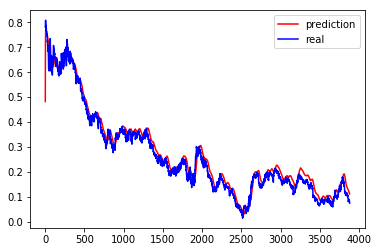

In [25]:
plt.plot(pred_train, 'r', label='prediction')
plt.plot(y_train, 'b', label='real')
plt.legend(loc='best')
plt.show()

### Testing result

In [23]:
var_data = Variable(x_test)
pred_test = net(var_data) # 测试集的预测结果
pred_test = pred_test.view(-1).data.numpy()
y_test = y_test.view(-1).data.numpy()

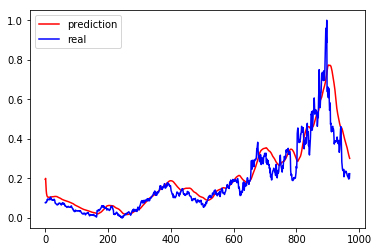

In [19]:
plt.plot(pred_test, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.legend(loc='best')
plt.show()